# Diversweaty



In [1]:
import numpy as np
import drawSvg as draw

In [2]:
colors = [[255, 0, 0], #red
      [225, 165, 0], # yellow
      [255, 255, 0], # orange
      #[229, 165, 73], #orange
      [120, 192, 95], # green
      [125, 137, 183], # blue
      #[125, 137, 183],# blue
      [152, 107, 146],#purple 
      [255, 0, 0]] #red
nb_part = len(colors)

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def color_gradient(prop, nb_col_component=nb_part):
    #input : 0<prop<1
    #output : a color
    k = int(prop*nb_col_component)
    if k != nb_col_component-1:
        col1 = colors[k]
        col2 = colors[k+1]
    else:
        col1 = colors[k]
        col2 = colors[0]
    prop = prop*nb_col_component-k
    return rgb_to_hex(tuple([int(prop*col2[i]+(1-prop)*col1[i]) for i in range(len(col1))]))

def add_section(d, ini_angle, color = "diverse", level = 1, stroke_width = 0.07, 
                start_angle = -50, final_angle = None):
    # inputs:
    ## level the "level" of the circle i.e. far from the center? 
    ## color the color of the section - can also be a gradient for the artists
    ## stroke_width the width of the border of the section. 
    ### -> in terms of aesthetic better be consistent across sections
    ## start_angle the angle of the first border of the section (degree)
    ### -> 0 = abcissa + positive (=360), 
    ### -> 90 = ordered + positive
    ### -> 180 = abcissa + negative
    ### -> 270 = ordered + negative
    ## final_angle of the other border of the section
    
    if not final_angle:
        final_angle = start_angle + 358
        
    # width of the blank area between the different levels
    margin = stroke_width + 0.04

    # reminder for p.arc function's arguments -> xcenter, ycenter, diameter, start angle, final angle
    # the path followed to construct the section
    if color=='random':
        prop = np.random.uniform(0,1)
        p = draw.Path(fill=color_gradient(prop), stroke='black', stroke_width=stroke_width)
    elif color=="diverse":
        prop = (((final_angle+start_angle)/2-ini_angle)%360)/360
        p = draw.Path(fill=color_gradient(prop), stroke='black', stroke_width=stroke_width)
    else:
        p = draw.Path(fill=color, stroke='black', stroke_width=stroke_width)
    # the path is composed of two arcs
    ## the first line being the line "under" the section
    p.arc(0, 0, 1+(level-1)*(1+margin), start_angle, final_angle)
    ## the second "over" the section
    p.arc(0, 0, 2+(level-1)*(1+margin), final_angle, start_angle, cw=True, includeL=True)
    # to "close" the section, draw the rest of the path
    p.Z()
    d.append(p)

def standard(d, ini_angle=310, color_angle=0, color = "diverse", level_max = 5, decrease_range_ratio=0.9):
    # inputs
    ## ini_angle the location of the first break on the first level
    ## color_angle : since the gradient of colors is computed based on ini_angle
    ### starting with red, purple, blue, etc., it provides a way to change the 
    ### position of the colors
    ## color of the section
    ### set to diverse it uses a similar set of colors as in the diverse logo
    ### set to random it uses random colors
    ### set to 'blue', 'red', 'black' it colors everything in plain color
    ## level_max the maximum level with colored sections
    ## decrease_range_ratio is specific to this variant
    ### on a level, the width of each section is decreasing as we draw
    ### the size of the next section is equals to the size of the previous section
    ### multiplied by this ratio
    
    
    # the positions of the break at each level
    ## e.g. positions[2] contains the breaks for level 2
    positions = dict()
    
    # draw level 1
    start_angle = ini_angle
    # for diverse we keep the first level in red
    if color == "diverse":
        add_section(d, ini_angle,
                    color = "red", level = 1, start_angle = start_angle)
    else:
        add_section(d, ini_angle, color = color, level = 1, start_angle = start_angle)
    positions[1] = [start_angle, start_angle-359]
    
    # draw levels 2 to level max
    for level in range(2, level_max+1):
        positions[level] = []
        for i in range(1, len(positions[level-1])):
            # we start on the breaks of the previous level, at s
            start_angle = positions[level-1][i-1]
            # to keep this break on the next level
            if start_angle not in positions[level]:
                positions[level].append(start_angle)
            # the end of the section in the previous level
            ## i.e. we "cannot" draw after this angle
            min_angle = positions[level-1][i]
            # the average angle of sections
            start_range = int((start_angle-min_angle)/4)
            # to bring some variations between different launches
            start_range_variation = 1+int((start_angle-min_angle)/20)
            end_section = False
            angle_current_section = None
            # get rid of too small sections that could not be printed on a sweat
            if np.abs(start_angle-min_angle) > 4:
                # while there remains space to draw
                while start_angle > min_angle and not end_section:
                    # if not defined already
                    # define the angle of the current section using a uniform dist
                    # see start_range and start_range_variation for the params
                    if not angle_current_section:
                        angle_current_section = int(np.random.uniform(start_range-start_range_variation,
                                                                      start_range+start_range_variation))
                    # else we decrease the current angle thx to the ratio
                    else:
                        angle_current_section = max(2, int(decrease_range_ratio*angle_current_section))
                    # if we can continue drawing 
                    if start_angle-angle_current_section-1.5> min_angle:
                        # we add a section
                        add_section(d, ini_angle+color_angle,
                                    color = color,
                                    level = level, 
                                    start_angle = start_angle-angle_current_section, 
                                    final_angle = start_angle)
                        # we change the strating angle of the future section
                        # with a margin break of 1.5 degree
                        start_angle=start_angle - angle_current_section-1.5
                        # we add the postion of the break in the table
                        positions[level].append(start_angle)
                    else:
                        # if the conditions are not respected, it is the end of the section
                        # and we go to the next section
                        end_section = True
                        
def mini(d, ini_angle=310, color_angle = 0, color = "diverse", decrease_range_ratio=0.9, level_max = 5):
    # same principle, but without cutting (too much) the angle between the different levels 
    start_angle = ini_angle
    positions = dict()
    if color == "diverse":
        add_section(d, ini_angle,
                    color = "red", level = 1, start_angle = start_angle)
    else:
        add_section(d, ini_angle, color = color, level = 1, start_angle = start_angle)
    positions[1] = [start_angle, start_angle-359]
    for level in range(2, level_max+1):
        positions[level] = []
        for i in range(1, len(positions[level-1])):
            s = positions[level-1][i-1]
            if s not in positions[level]:
                positions[level].append(s)
            min_angle = positions[level-1][i]
            start_range = int((start_angle-min_angle)/4)
            start_range_variation = 1+int((start_angle-min_angle)/20)
            end_section = False
            angle_current_section = None
            while s > min_angle and not end_section:
                if not angle_current_section:
                    angle_current_section = int(np.random.uniform(start_range-start_range_variation,
                                                                  start_range+start_range_variation))
                else:
                    angle_current_section = max(2, int(decrease_range_ratio*angle_current_section))
                if s-angle_current_section-1.5> min_angle:
                    add_section(d, ini_angle+color_angle,
                                level = level, start_angle = s-angle_current_section, final_angle=s)
                    s=s - angle_current_section-1.5
                    positions[level].append(s)
                else:
                    end_section = True



def scattered(d, ini_angle=310, color_angle=0, color = "diverse", level_max = 5, proba = 0.8, side = 'both'):
    # the idea is to fill all the circle 
    # and then to remove randomly some section in the middle
    # new inputs
    ## proba the probability of removing a section
    ### e.g. set to 0 it display a full logo
    ## side to select a half of the graph to keep - values:
    ### left to keep left, right to keep right half, both default
    start_angle = ini_angle
    positions = dict()
    ## level 1
    if color == "diverse":
        add_section(d, ini_angle,
                    color = "red", level = 1, start_angle = start_angle)
    else:
        add_section(d, ini_angle, color = color, level = 1, start_angle = start_angle)
    if side =='left':
        positions[1] = [start_angle, start_angle-179]
    elif side == 'right':
        positions[1] = [start_angle-179, start_angle-359]
    else:
        positions[1] = [start_angle, start_angle-359]
    for level in range(2, level_max+1):
        positions[level] = []
        for index_pos in range(1, len(positions[level-1])):
            s = positions[level-1][index_pos-1]
            min_angle = positions[level-1][index_pos]
            if s not in positions[level]:
                positions[level].append(s)
            start_range = int((start_angle-min_angle)/15)
            start_range_variation = 1+int((start_angle-min_angle)/20)
            if np.abs(start_angle-min_angle) > 2:
                angle_current_section = None
                while s > min_angle:
                    if not angle_current_section:
                        angle_current_section = int(np.random.uniform(start_range-start_range_variation,
                                                                      start_range+start_range_variation))

                    if s-angle_current_section > min_angle and angle_current_section>3:
                        if np.random.uniform(0,1)>proba:
                            add_section(d, ini_angle+color_angle,
                                        level = level, 
                                        start_angle = s-angle_current_section, 
                                        final_angle = s)
                        s = s-angle_current_section-3
                    else:
                        if np.random.uniform(0,1)>proba:
                            if np.abs(s-min_angle) > 5:
                                add_section(d, ini_angle+color_angle,
                                            level = level, 
                                            start_angle = min_angle+2, 
                                            final_angle = s)
                        s = min_angle
                    positions[level].append(s)

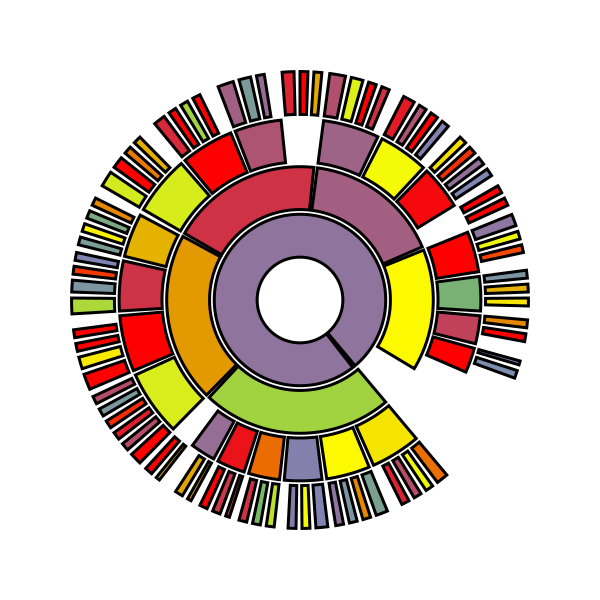

In [4]:
d = draw.Drawing(14, 14, origin='center')
standard(d, level_max = 4, color_angle = 45, color = 'random')
d.setRenderSize(w=600)
d.saveSvg('logos/standard3.svg')
d

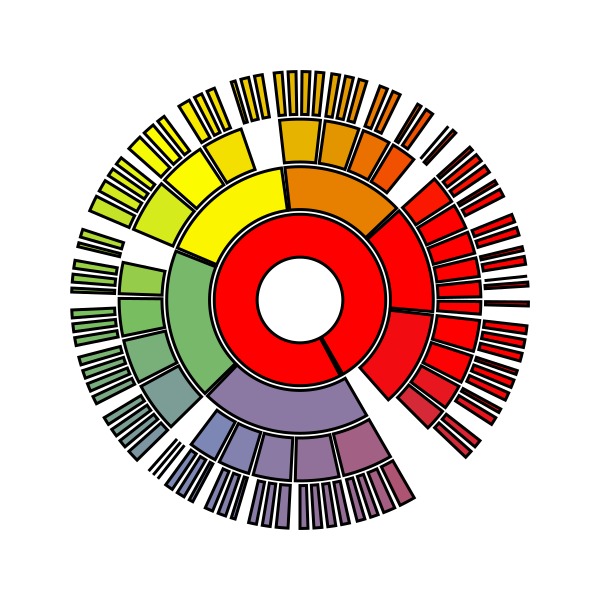

In [34]:
d = draw.Drawing(14, 14, origin='center')
standard(d, ini_angle = 300, level_max = 4, color_angle = 90, color = 'diverse')
d.setRenderSize(w=600)
d.saveSvg('logos/standard5.svg')
d

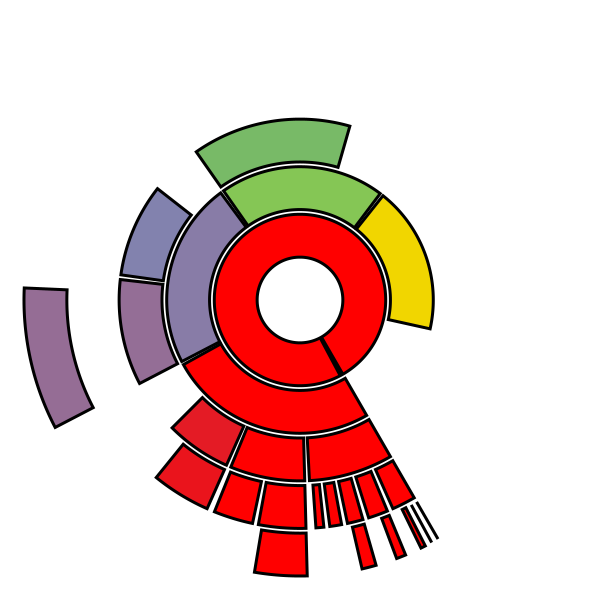

In [35]:
d = draw.Drawing(14, 14, origin='center')
mini(d, ini_angle = 300)
d.setRenderSize(w=600)
d.saveSvg('logos/mini3.svg')
d

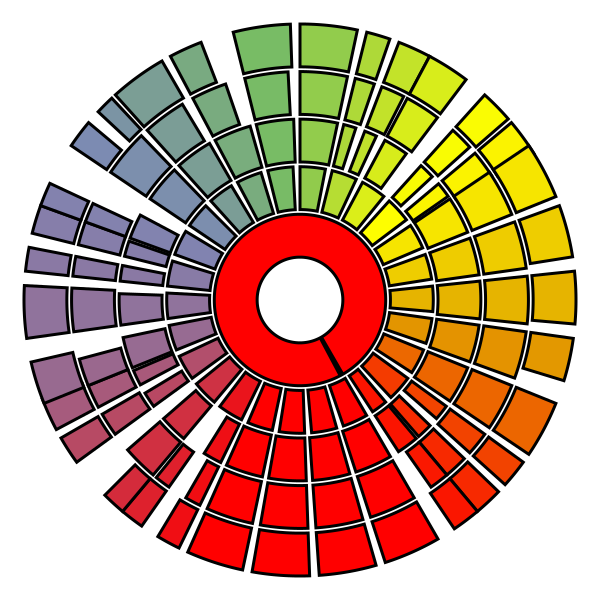

In [36]:
d = draw.Drawing(14, 14, origin='center')
scattered(d, ini_angle = 300, color_angle= 0, proba = 0, side ='both')     
d.setRenderSize(w=600)
d.saveSvg('logos/full4.svg')
d

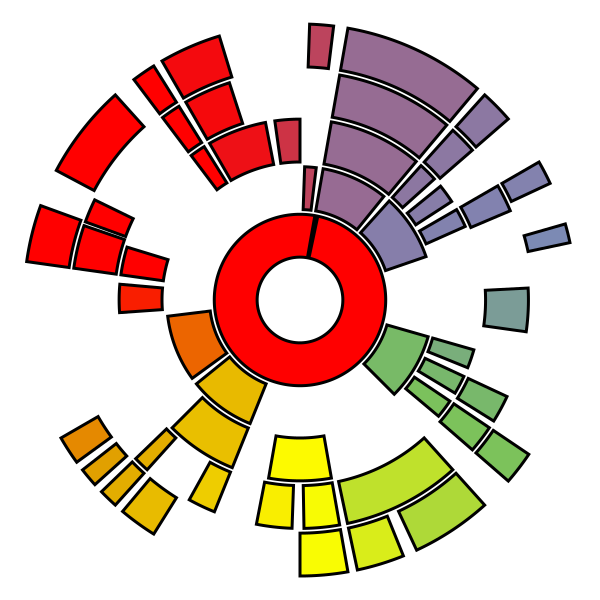

In [18]:
d = draw.Drawing(14, 14, origin='center')
scattered(d, ini_angle = 80, color_angle= 90, proba = 0.5, side ='both')     
d.setRenderSize(w=600)
d.saveSvg('logos/scattered1.svg')
d

color random or not

symetrical or not 

dimishing the size of sections between the different levels

todo:

other variants

doc

notebook

downloadable svgs in colab